In [1]:
from ngsolve.webgui import Draw

import numpy as np
import ngsolve as ng

motor_npz = np.load('../meshes/motor_pizza_gap.npz', allow_pickle = True)

geoOCC = motor_npz['geoOCC'].tolist()
m = motor_npz['m']; m_new = m
j3 = motor_npz['j3']

geoOCCmesh = geoOCC.GenerateMesh()
mesh = ng.Mesh(geoOCCmesh)
mesh.Refine()
mesh.Refine()

# Draw(mesh)
# HCurl = ng.HCurl(mesh, order = 2, nograds = True, dirichlet = 'left|right')
# help(mesh)
# help(HCurl.mesh)


In [2]:
HCurl = ng.HCurl(mesh, order = 2, nograds = True, dirichlet = 'left|right|stator_outer')
# mesh.Refine()
# HCurl = ng.HCurl(mesh, order = 2, nograds = True)

print(HCurl.mesh.levels)

u,v = HCurl.TnT()

K = ng.BilinearForm(HCurl)
# K += (ng.curl(u)*ng.curl(v)+1e-5*u*v)*ng.dx
K += (ng.curl(u)*ng.curl(v)+0*u*v)*ng.dx
K.Assemble()

f = ng.LinearForm(HCurl)
f += ng.InnerProduct(ng.CF(ng.x),ng.curl(v))*ng.dx
# f += ng.CF((1,1))*v*ng.dx
f.Assemble()

# rows,cols,vals = K.mat.COO()
# import scipy.sparse as sp
# ngK = sp.csr_matrix((vals,(rows,cols)))

# np.linalg.matrix_rank(ngK.A)
# print(ngK.shape)

3


In [3]:
# import sys
# sys.path.insert(0,'../../') # adds parent directory

# import pde
# MESH = pde.mesh.netgen(mesh.ngmesh)
# print(MESH.NoEdges,MESH.nt,MESH.np)

# List all edges... this is still kinda slow but what can you do
i = 0
count = 0
edges = []
for edge in mesh.edges:
    index = HCurl.FreeDofs()[i]
    edge = [int(str(edge.vertices[0])[1:]), int(str(edge.vertices[1])[1:]), i]
    i = i + 1
    if HCurl.CouplingType(i)!=ng.comp.COUPLING_TYPE.UNUSED_DOF:
        if index == 1:
            # Append only FreeDof edges.
            edges.append(edge)
        else:
            # Non-Freedof edges appended at start!
            edges.insert(0, edge)
            count = count + 1

edges = np.array(edges)
# print(HCurl.FreeDofs())
print(edges.shape,mesh.nedge,HCurl.ndof)
# edges[:200]
print(count)

# HCurl.Prolongation().Operator(1)
# HCurl.Prolongation().LevelDofs(1)
# help(mesh.ngmesh)

# print(edges)
# edges[np.argwhere(edges==8360)[:,0],:]

# H1 = ng.H1(mesh, order = 1, dirichlet = 'left|right')
# print(HCurl.mesh.levels)
# print(HCurl.Prolongation().LevelDofs(0))
# help(HCurl.Prolongation().LevelDofs(1))
# HCurl.Prolongation().LevelDofs(0).stop


# KK = HCurl.Prolongation()
# print(KK.start,KK.stop)
# print(H1.FreeDofs())

(150577, 3) 198219 397195
249


In [11]:
mesh.ngmesh.Elements2D().NumPy()['index'].astype(np.uint64).shape
mesh.ne

99488

In [ ]:
from mst5 import *
g = Graph(mesh.nv)
g.addEdges(edges)
mst = g.KruskalMST()

tree_indices = np.array(mst)[:,2]
print(tree_indices.size,mesh.nv)

51088 51090


In [ ]:
import pyngcore as pyng
FreeDofsCotreeGauge = pyng.BitArray(HCurl.FreeDofs())
for i,j in enumerate(tree_indices): 
    # if FreeDofsCotreeGauge[j]==0:
    #     print('we have a problem',j)
    FreeDofsCotreeGauge.Clear(j)

print(mesh.ne,mesh.nv,mesh.nedge)

# print(HCurl.FreeDofs())
# 01010010010011101011111111111111111111111111111111
# 01100100110101101011100

uc = ng.GridFunction(HCurl, name="uc")
uc.vec[:] = 0
uc.vec[:1] = 10
# ng.SetVisualization(min=0, max=3)
Draw(uc, vectors={"grid_size":100})

# HCurl.ndof

# print()


99488 51090 198219


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [ ]:
A = ng.GridFunction(HCurl)
A.vec.data = K.mat.Inverse(freedofs = FreeDofsCotreeGauge, inverse = 'sparsecholesky')*f.vec
# A.vec.data = K.mat.Inverse(HCurl.FreeDofs(), inverse = 'sparsecholesky')*f.vec

Draw(A, vectors={"grid_size":100})
Draw(ng.curl(A), mesh)
# A.vec.data.FV().NumPy().max()
# np.where(FreeDofsCotreeGauge)[0].shape

# ng.Integrate(ng.curl(A),mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

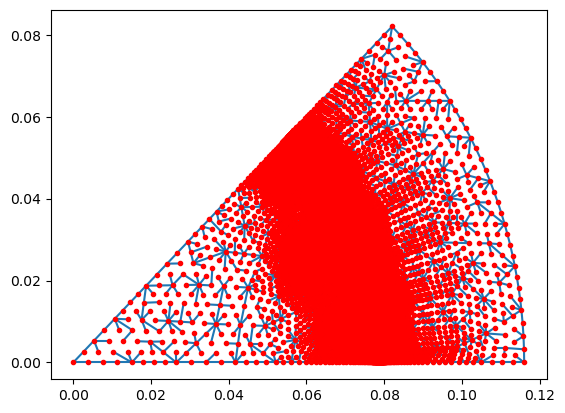

In [ ]:
import numpy
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# %matplotlib qt

# points = []
# for vertex in mesh.vertices:
#     points.append(list(vertex.point))
# points = np.array(points)
# nmst = np.array(mst)

# lc = LineCollection(points[nmst[:,:2]])
# # lc = LineCollection(points[edges[10028:,:2]])

# fig = plt.figure()
# plt.gca().add_collection(lc)
# plt.plot(points[:,0], points[:,1], 'r.')

# plt.show()

# edges.shape

# mesh.dim

points = []
for vertex in mesh.vertices:
    points.append(list(vertex.point))
points = np.array(points)
nmst = np.array(mst)

fig = plt.figure()
if mesh.dim == 2:
    lc = LineCollection(points[nmst[:,:2]])
    plt.gca().add_collection(lc)
    plt.plot(points[:,0], points[:,1], 'r.')
if mesh.dim == 3:
    # edges = [(points[start], points[end]) for start, end in nmst]
    # lc = Line3DCollection(edges)
    lc = Line3DCollection(points[nmst[:,:2]])
    plt.gca().add_collection(lc)
    plt.plot(points[:,0], points[:,1], points[:,2], 'r.')

plt.show()

In [ ]:
mesh.vertices[0]

V0

In [ ]:
points[1442]

array([0.06880241, 0.06880241])

In [ ]:
nmst[:6]

array([[ 13019,  51042, 147754],
       [ 13019,  49071, 147753],
       [ 12928,  50991, 147029],
       [ 12928,  36460, 147027],
       [ 12926,  50989, 147016],
       [ 12926,  49016, 147015]])

In [14]:
lam0 = lambda x,y,z : 1-x-y-z
lam1 = lambda x,y,z : x
lam2 = lambda x,y,z : y
lam3 = lambda x,y,z : z

Dlam0 = lambda x,y,z : np.r_[-1,-1,-1]
Dlam1 = lambda x,y,z : np.r_[ 1, 0, 0]
Dlam2 = lambda x,y,z : np.r_[ 0, 1, 0]
Dlam3 = lambda x,y,z : np.r_[ 0, 0, 1]
    
LISTS = {}
LISTS['N0'] = {}
LISTS['N0']['TET'] = {}

LISTS['N0']['TET']['phi'] = {}
LISTS['N0']['TET']['phi'][0] = lambda x,y,z: lam0(x,y,z)*Dlam1(x,y,z)-lam1(x,y,z)*Dlam0(x,y,z)
LISTS['N0']['TET']['phi'][1] = lambda x,y,z: lam0(x,y,z)*Dlam2(x,y,z)-lam2(x,y,z)*Dlam0(x,y,z)
LISTS['N0']['TET']['phi'][2] = lambda x,y,z: lam0(x,y,z)*Dlam3(x,y,z)-lam3(x,y,z)*Dlam0(x,y,z)
LISTS['N0']['TET']['phi'][3] = lambda x,y,z: lam1(x,y,z)*Dlam2(x,y,z)-lam2(x,y,z)*Dlam1(x,y,z)
LISTS['N0']['TET']['phi'][4] = lambda x,y,z: lam1(x,y,z)*Dlam3(x,y,z)-lam3(x,y,z)*Dlam1(x,y,z)
LISTS['N0']['TET']['phi'][5] = lambda x,y,z: lam2(x,y,z)*Dlam3(x,y,z)-lam3(x,y,z)*Dlam2(x,y,z)

LISTS['N0']['TET']['curlphi'] = {}
LISTS['N0']['TET']['curlphi'][0] = lambda x,y,z: np.cross(Dlam0(x,y,z),Dlam1(x,y,z))-np.cross(Dlam1(x,y,z),Dlam0(x,y,z))
LISTS['N0']['TET']['curlphi'][1] = lambda x,y,z: np.cross(Dlam0(x,y,z),Dlam2(x,y,z))-np.cross(Dlam2(x,y,z),Dlam0(x,y,z))
LISTS['N0']['TET']['curlphi'][2] = lambda x,y,z: np.cross(Dlam0(x,y,z),Dlam3(x,y,z))-np.cross(Dlam3(x,y,z),Dlam0(x,y,z))
LISTS['N0']['TET']['curlphi'][3] = lambda x,y,z: np.cross(Dlam1(x,y,z),Dlam2(x,y,z))-np.cross(Dlam2(x,y,z),Dlam1(x,y,z))
LISTS['N0']['TET']['curlphi'][4] = lambda x,y,z: np.cross(Dlam1(x,y,z),Dlam3(x,y,z))-np.cross(Dlam3(x,y,z),Dlam1(x,y,z))
LISTS['N0']['TET']['curlphi'][5] = lambda x,y,z: np.cross(Dlam2(x,y,z),Dlam3(x,y,z))-np.cross(Dlam3(x,y,z),Dlam2(x,y,z))

In [37]:
lam0 = lambda x,y : 1-x-y
lam1 = lambda x,y : x
lam2 = lambda x,y : y

Dlam0 = lambda x,y : np.r_[-1,-1]
Dlam1 = lambda x,y : np.r_[ 1, 0]
Dlam2 = lambda x,y : np.r_[ 0, 1]
    
LISTS = {}
LISTS['N0'] = {}
LISTS['N0']['TET'] = {}

LISTS['N0']['TET']['phi'] = {}
LISTS['N0']['TET']['phi'][0] = lambda x,y: lam0(x,y)*Dlam1(x,y)-lam1(x,y)*Dlam0(x,y)
LISTS['N0']['TET']['phi'][1] = lambda x,y: lam1(x,y)*Dlam2(x,y)-lam2(x,y)*Dlam1(x,y)
LISTS['N0']['TET']['phi'][2] = lambda x,y: lam2(x,y)*Dlam0(x,y)-lam0(x,y)*Dlam2(x,y)

LISTS['N0']['TET']['curlphi'] = {}
LISTS['N0']['TET']['curlphi'][0] = lambda x,y: np.cross(Dlam0(x,y),Dlam1(x,y))-np.cross(Dlam1(x,y),Dlam0(x,y))
LISTS['N0']['TET']['curlphi'][1] = lambda x,y: np.cross(Dlam1(x,y),Dlam2(x,y))-np.cross(Dlam2(x,y),Dlam1(x,y))
LISTS['N0']['TET']['curlphi'][2] = lambda x,y: np.cross(Dlam2(x,y),Dlam0(x,y))-np.cross(Dlam0(x,y),Dlam2(x,y))

In [1]:
from sympy import symbols
x, y = symbols('x y')

print(LISTS['N0']['TET']['curlphi'][0](x,y),\
      LISTS['N0']['TET']['curlphi'][1](x,y),\
      LISTS['N0']['TET']['curlphi'][2](x,y))

print(LISTS['N0']['TET']['phi'][0](x,y),\
      LISTS['N0']['TET']['phi'][1](x,y),\
      LISTS['N0']['TET']['phi'][2](x,y))

NameError: name 'LISTS' is not defined